In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
!pwd

/home/as111/sipm-analysis


In [7]:
# data folder
path = "/scratch/gpfs/as111/results/2023-07-27"
data_spe = {}
channels = [0, 1, 2, 3]
voltages = [94, 96]
for ch in channels:
    data_spe[ch] = {}
    for volt in voltages:
        data_spe[ch][volt] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
        files = glob.glob(f"{path}/*volt_{volt}*laser_waveform_liq4.h5")
        print(files)
        for f in files:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            data_spe[ch][volt]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
            if data_spe[ch][volt]['time'].shape[0]==0:
                data_spe[ch][volt]['time'] = np.array(df['time'])
            if np.array(df['n_spe_wfs'])[0]>0:
                if data_spe[ch][volt]['avg_spe_wf'].shape[0]==0:
                    data_spe[ch][volt]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
                else:
                    data_spe[ch][volt]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
        df = None
        if data_spe[ch][volt]['n_spe_wfs']>0:
            data_spe[ch][volt]['avg_spe_wf'] /= data_spe[ch][volt]['n_spe_wfs']

['/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_94_light_laser_cond_ln_intensity_800_config_2_intensity_800_run4_laser_waveform_liq4.h5', '/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_94_light_laser_cond_ln_intensity_800_config_2_intensity_800_run2_laser_waveform_liq4.h5', '/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_94_light_laser_cond_ln_intensity_800_config_2_intensity_800_run1_laser_waveform_liq4.h5', '/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_94_light_laser_cond_ln_intensity_800_config_2_intensity_800_run3_laser_waveform_liq4.h5', '/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_94_light_laser_cond_ln_intensity_800_config_2_intensity_800_run0_laser_waveform_liq4.h5']
['/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_96_light_laser_cond_ln_intensity_800_config_2_intensity_800_run2_laser_waveform_liq4.h5', '/scratch/gpfs/as111/results/2023-07-27/2023-07-27_volt_96_light_laser_cond_ln_intensity_800_config_2_intensity_800_run0_l

ch0 94V 6411 waveforms selected
ch1 94V 16043 waveforms selected
ch2 94V 12535 waveforms selected
ch3 94V 21050 waveforms selected
ch0 96V 3471 waveforms selected
ch1 96V 11359 waveforms selected
ch2 96V 8035 waveforms selected
ch3 96V 16419 waveforms selected


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

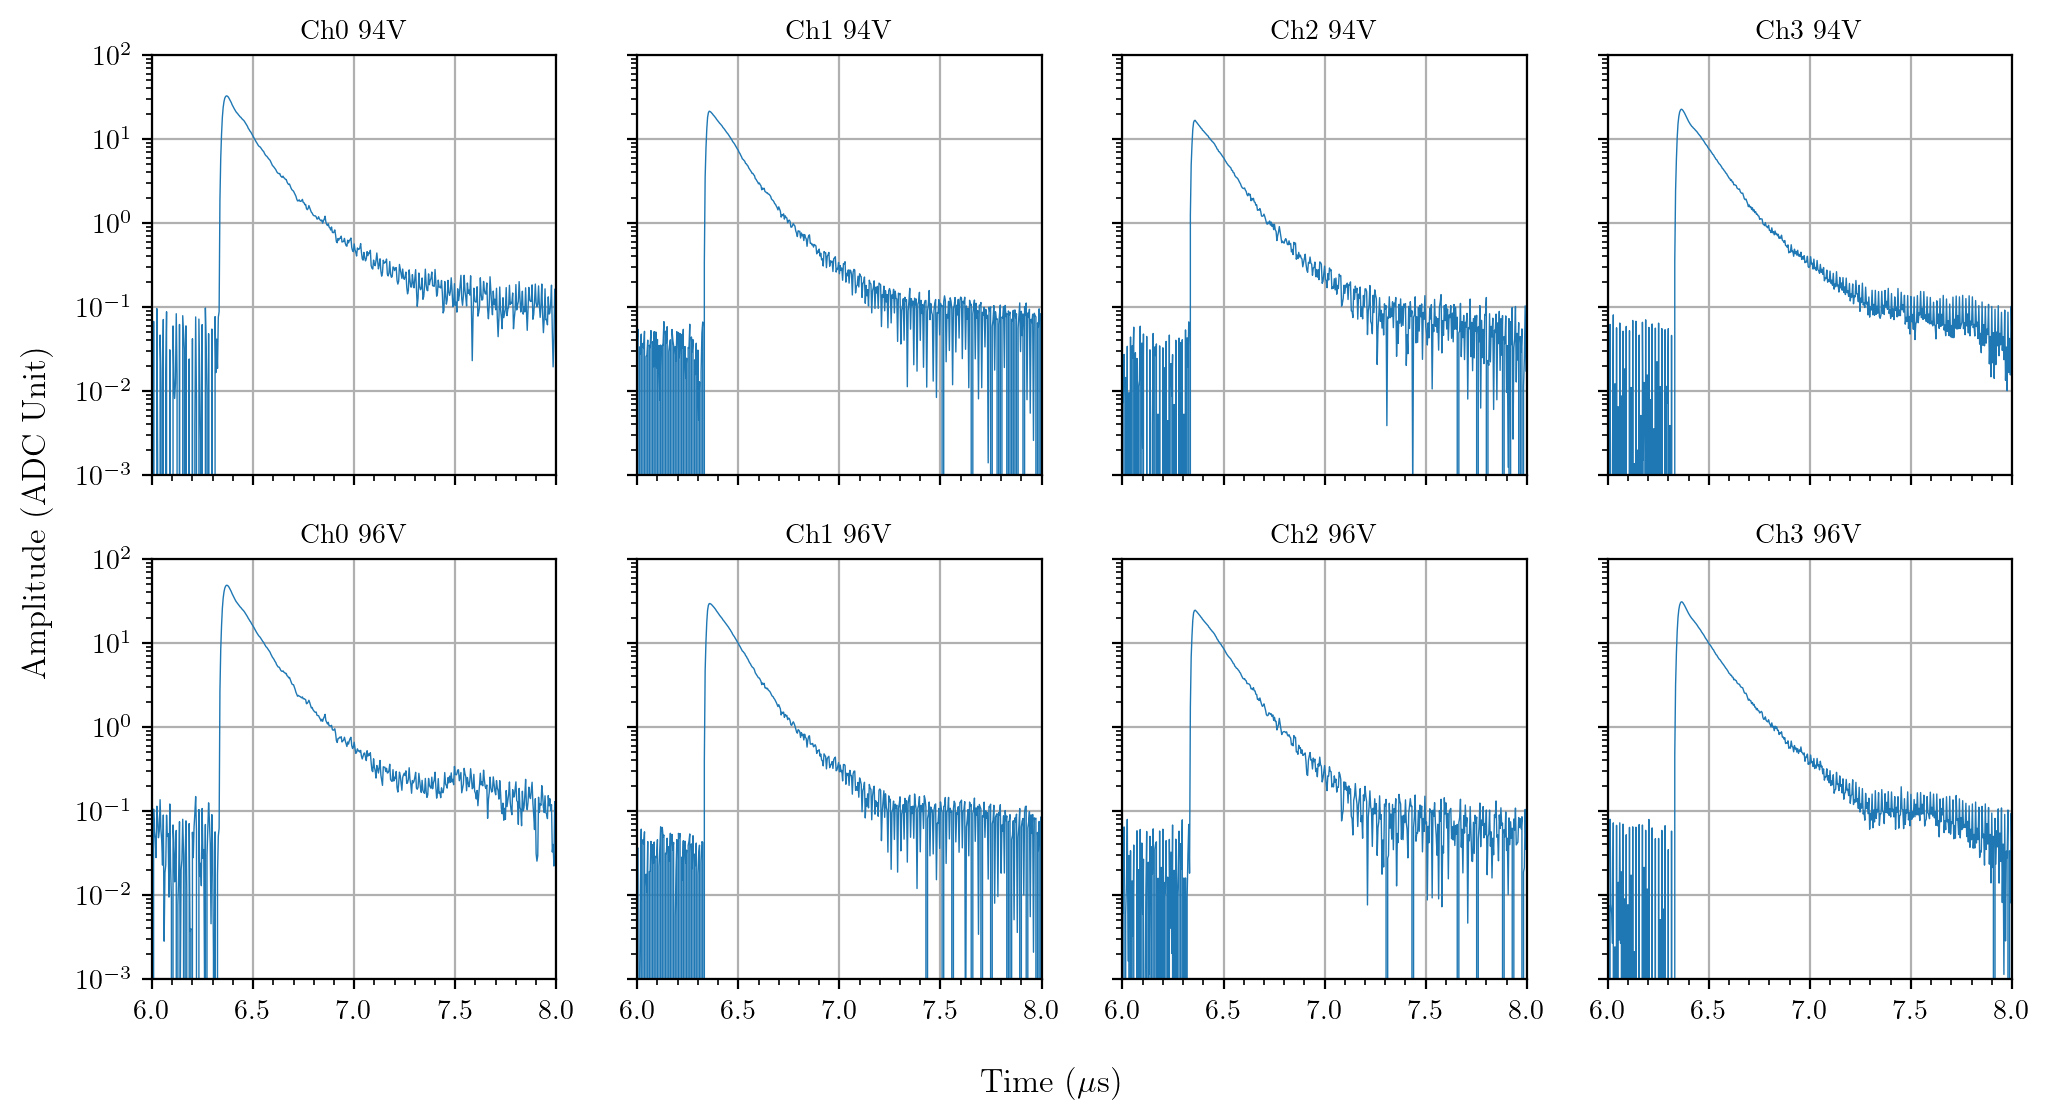

In [8]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(len(voltages), len(channels), sharex=True, sharey=True)
fig.set_size_inches(len(channels)*3, len(voltages)*3)
for i, volt in enumerate(voltages):
    for j, ch in enumerate(channels):
        if data_spe[ch][volt]['n_spe_wfs']>0:
            print(f'ch{ch} {volt}V {data_spe[ch][volt]["n_spe_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_spe[ch][volt]['time'],
                data_spe[ch][volt]['avg_spe_wf'],linewidth=0.5)
        axs[i, j].set_xlim(6, 8)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'Ch{ch} {volt}V')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

## FFT

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

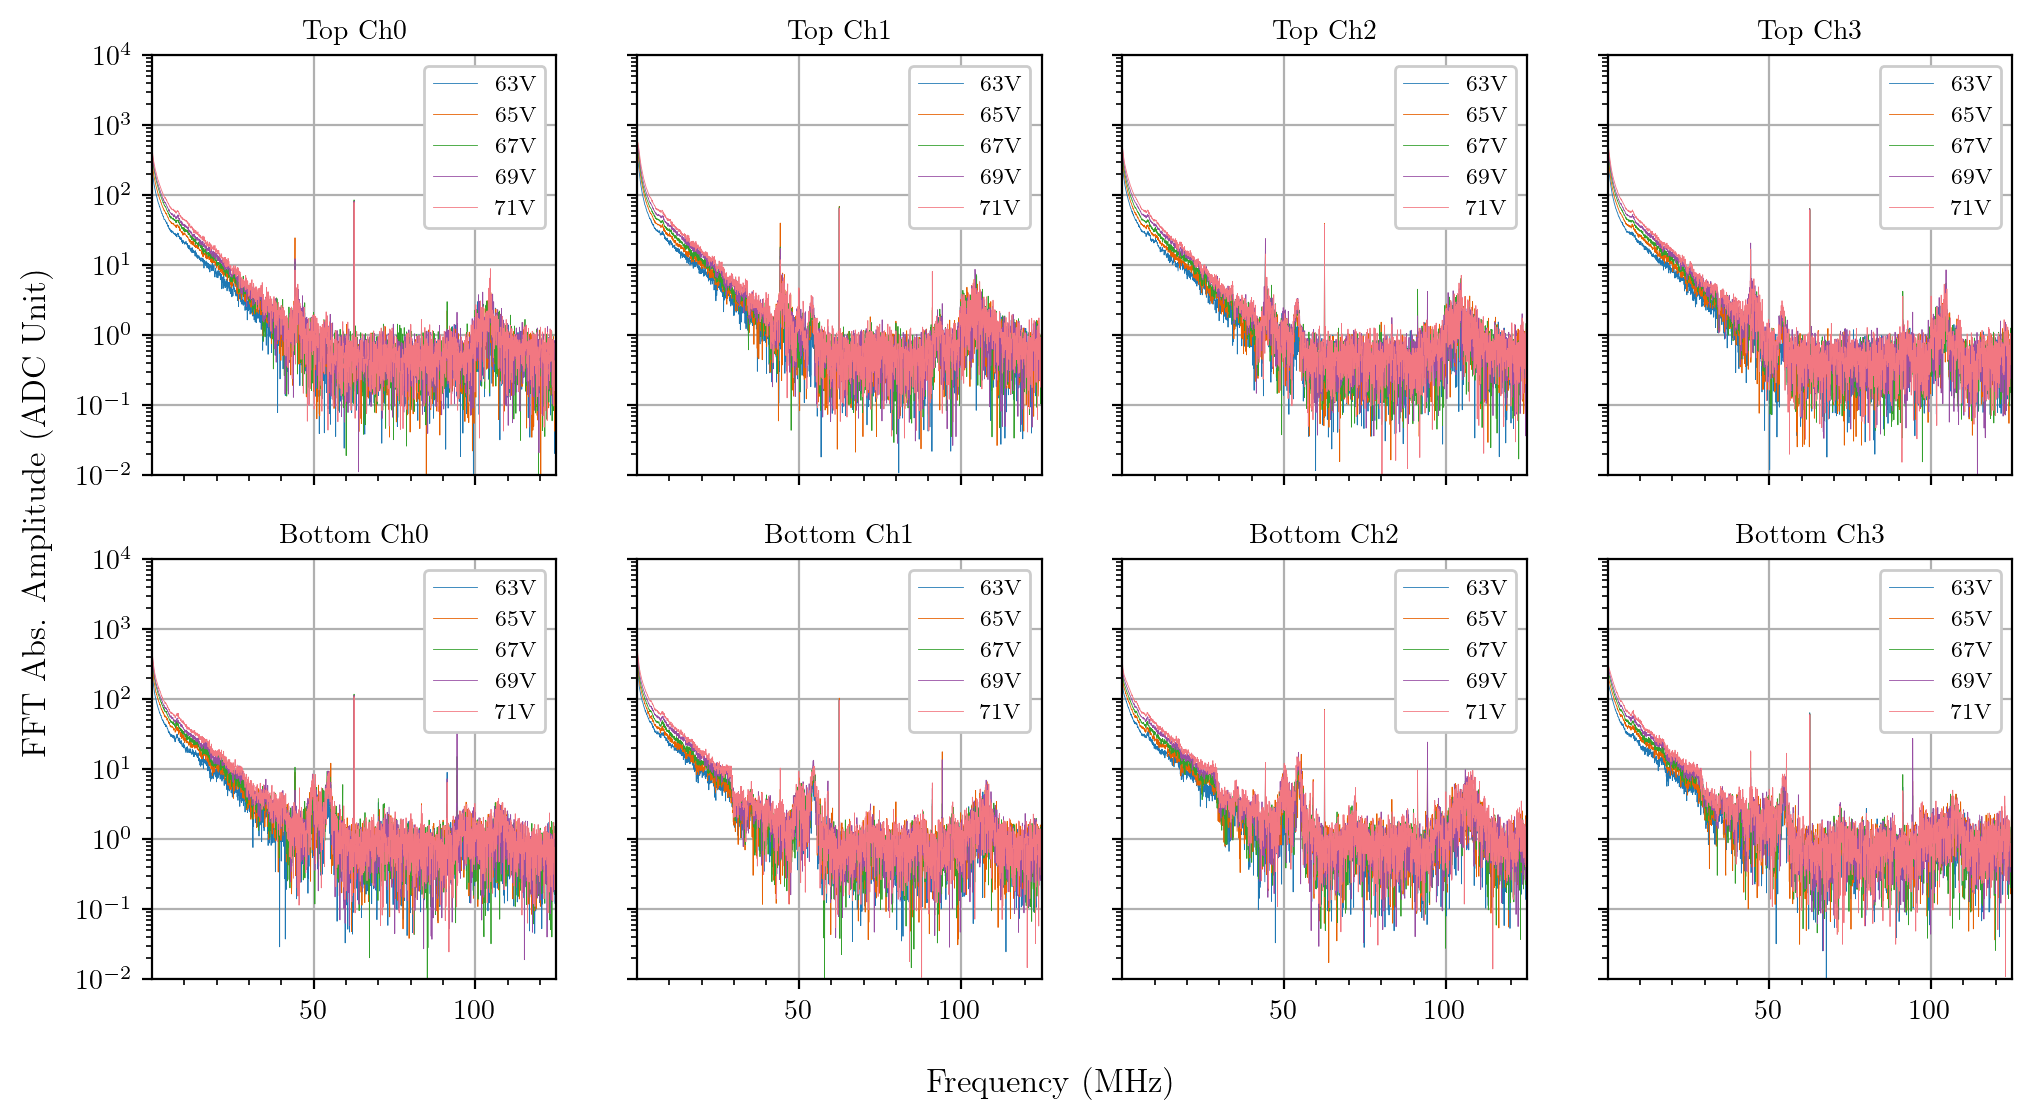

In [6]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_spe[pos][ch][volt]['fft_spe_wf'] = fft(data_spe[pos][ch][volt]['avg_spe_wf'])
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            t_total = dt+data_spe[pos][ch][volt]['time'][-1]
            n_over_2 = int(data_spe[pos][ch][volt]['time'].shape[0]/2)
            data_spe[pos][ch][volt]['frequency'] = data_spe[pos][ch][volt]['time']/dt/t_total
            axs[i, j].plot(
                data_spe[pos][ch][volt]['frequency'][:n_over_2],
                abs(data_spe[pos][ch][volt]['fft_spe_wf'][:n_over_2]),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(data_spe[pos][ch][volt]['frequency'][1], data_spe[pos][ch][volt]['frequency'][n_over_2])
        # axs[i, j].set_xlim(0,5)
        axs[i, j].set_ylim(1e-2, 1e4)
        # axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Fit: exponential pulses with time jitter
Scintillation pulse (one component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$
We include two scintillation pulse components with distinct $\tau$.

In [7]:
def template(t, a_1, tau_1, a_2, tau_2, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [8]:
# Fit SPE average waveform
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            pretrg = 5 #us
            err = np.std(data_spe[pos][ch][volt]['avg_spe_wf'][data_spe[pos][ch][volt]['time']<pretrg])
            fit_range = [6.2,10] #us
            range_arr = (data_spe[pos][ch][volt]['time']<fit_range[1])&(data_spe[pos][ch][volt]['time']>fit_range[0])
            # print(pos,ch,volt)
            # print(data_spe[pos][ch][volt]['time'][range_arr])
            # print(data_spe[pos][ch][volt]['avg_spe_wf'][range_arr])
            popt,pcov = curve_fit(
                template,
                data_spe[pos][ch][volt]['time'][range_arr], 
                data_spe[pos][ch][volt]['avg_spe_wf'][range_arr], 
                p0=[7, 0.05, 6, 0.7, 0.008, 6.34], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
            data_spe[pos][ch][volt]['pars'] = popt
            data_spe[pos][ch][volt]['cov'] = pcov

/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/util/functions.py:24: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


Text(0.07, 0.5, 'Amplitude (ADC Unit)')

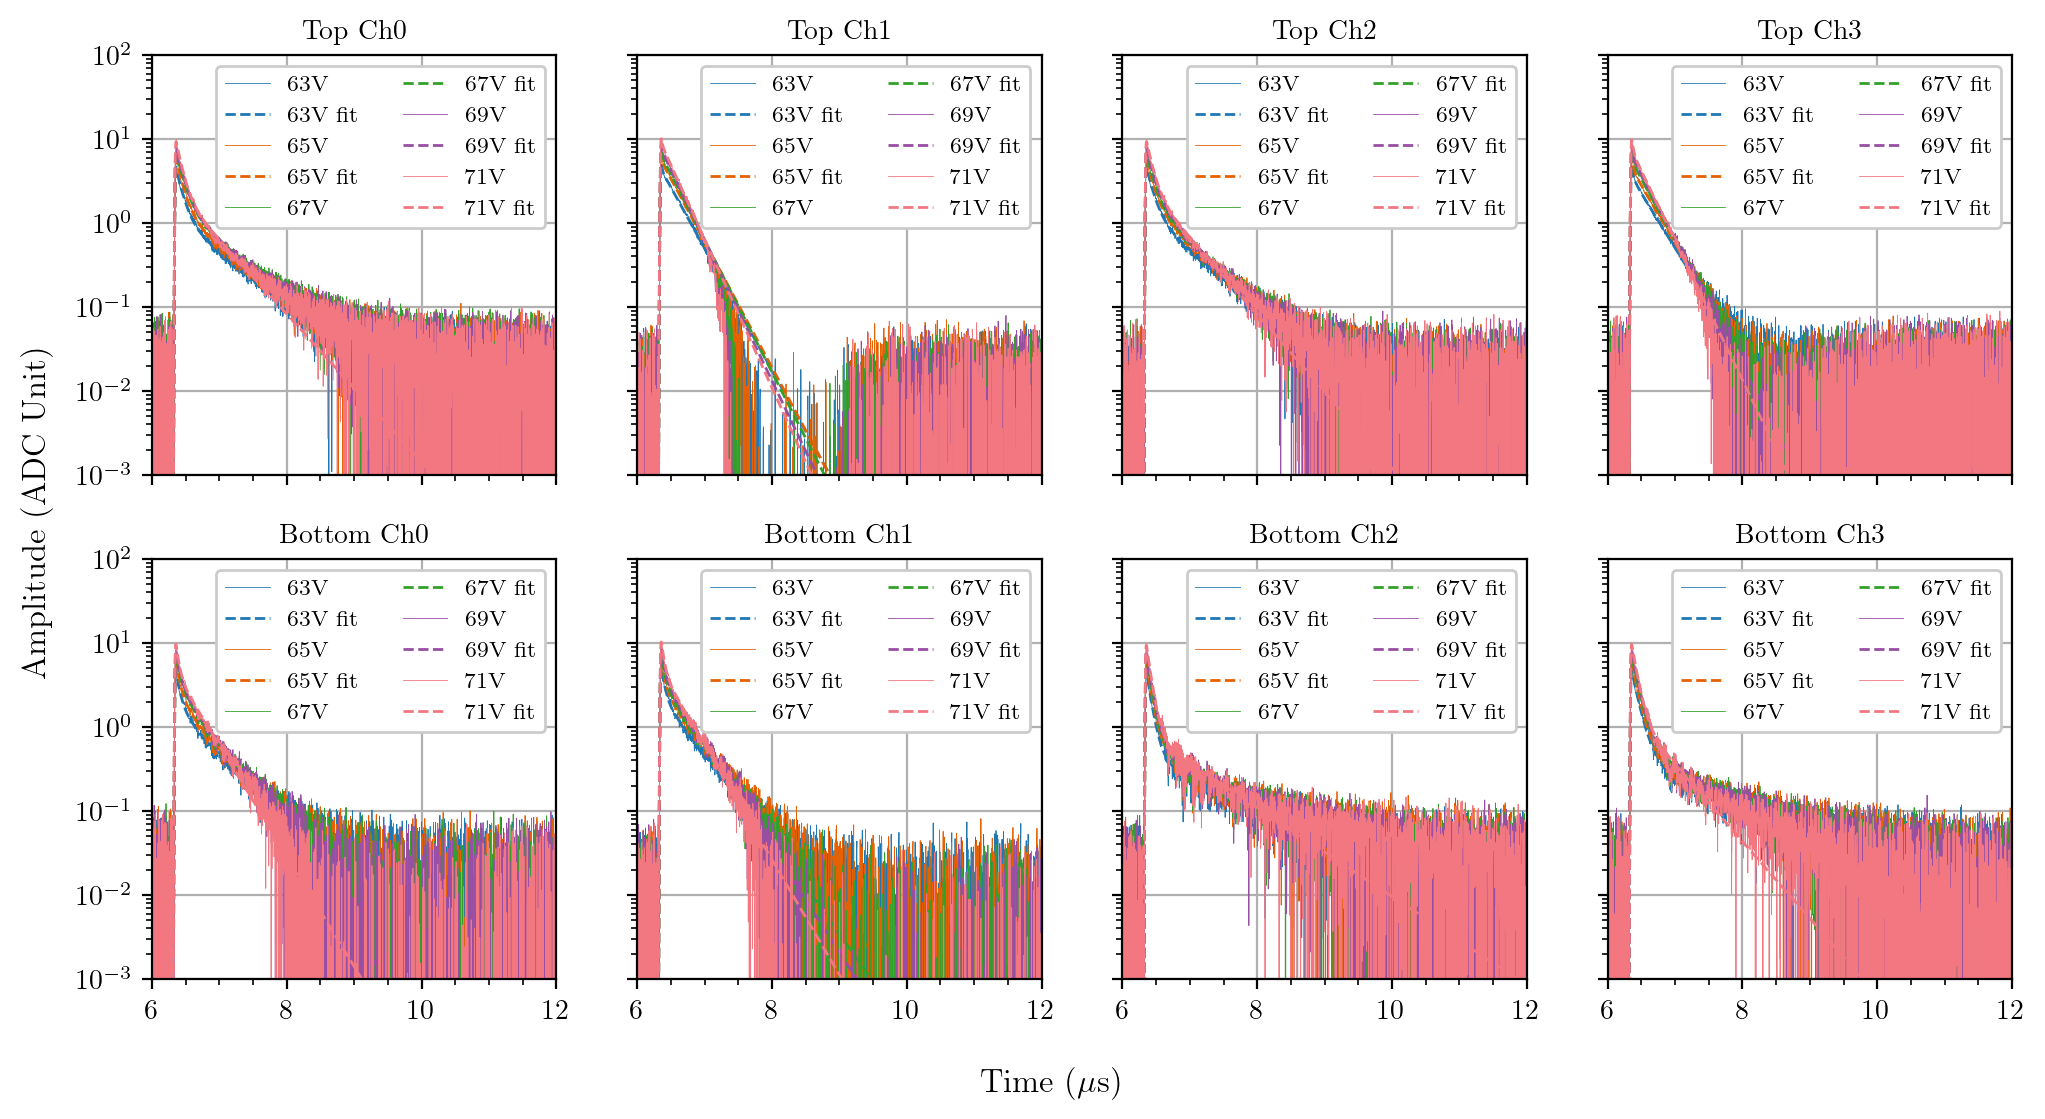

In [9]:
# Make plots for all datasets
# Fitted SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                data_spe[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                template(data_spe[pos][ch][volt]['time'], *data_spe[pos][ch][volt]['pars']),
                label=f'{volt}V fit', color=f'C{k}', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right',ncol=2)
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [10]:
# Fit result container
# Initialize
spe_fit = {}
for pos in positions:
    spe_fit[pos] = {}
    for ch in channels:
        spe_fit[pos][ch] = {}

In [11]:
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
            spe_fit[pos][ch]['volts'] = np.array(voltages)
            spe_fit[pos][ch]['a1'] = np.array([data_spe[pos][ch][volt]['pars'][0] for volt in voltages])
            spe_fit[pos][ch]['tau1'] = np.array([data_spe[pos][ch][volt]['pars'][1] for volt in voltages])
            spe_fit[pos][ch]['a2'] = np.array([data_spe[pos][ch][volt]['pars'][2] for volt in voltages])
            spe_fit[pos][ch]['tau2'] = np.array([data_spe[pos][ch][volt]['pars'][3] for volt in voltages])
            spe_fit[pos][ch]['a1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][0, 0]) for volt in voltages])
            spe_fit[pos][ch]['tau1err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][1, 1]) for volt in voltages])
            spe_fit[pos][ch]['a2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][2, 2]) for volt in voltages])
            spe_fit[pos][ch]['tau2err'] = np.array([func.error_distance(df=6, sigma=1)*np.sqrt(data_spe[pos][ch][volt]['cov'][3, 3]) for volt in voltages])

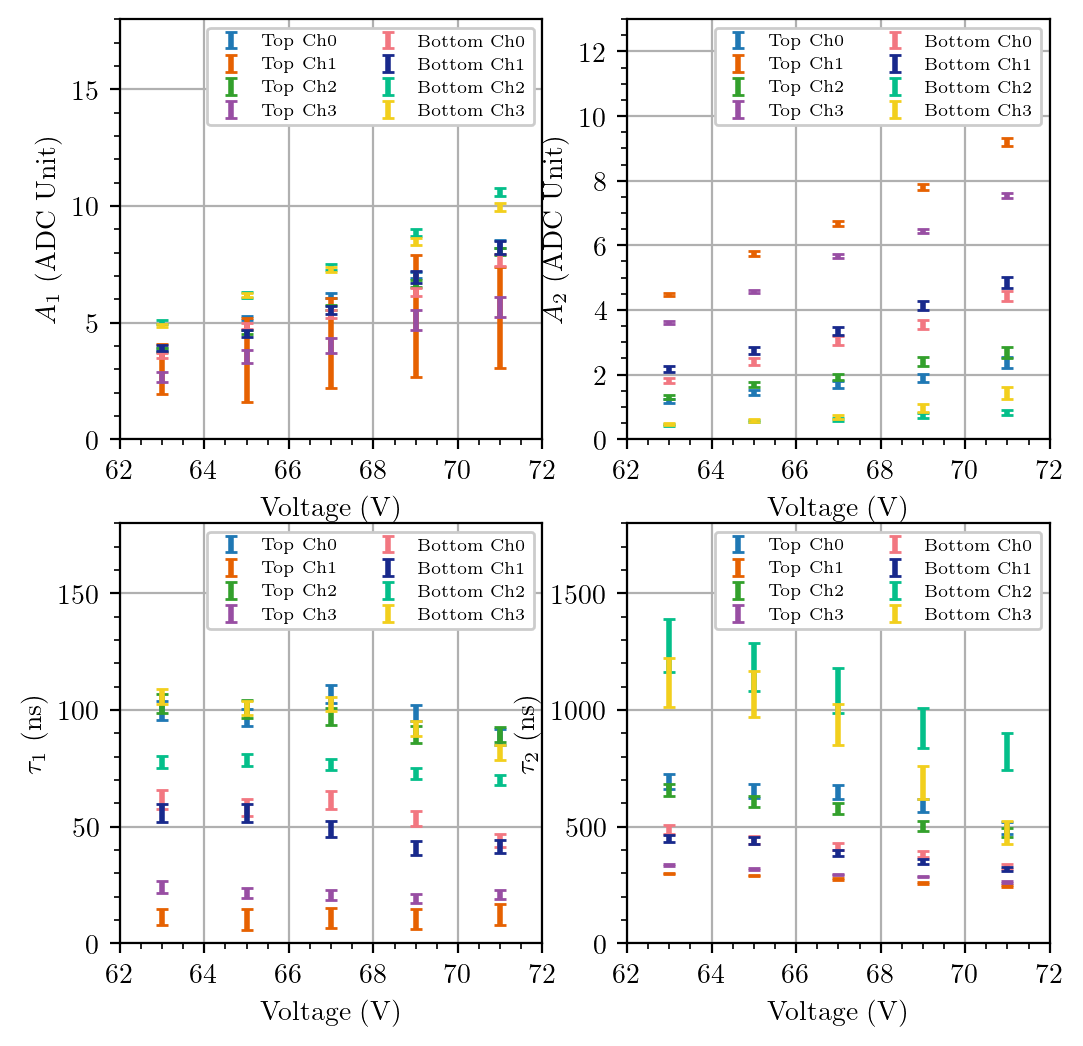

In [12]:
# Make plots for all parameters
# SPE average waveform
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        axs[0, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a1'],
            yerr=spe_fit[pos][ch]['a1err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 0].set_ylabel(r'$A_1$ (ADC Unit)')
        axs[0, 0].set_ylim(0,18)
        axs[0, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['a2'],
            yerr=spe_fit[pos][ch]['a2err'],
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[0, 1].set_ylabel(r'$A_2$ (ADC Unit)')
        axs[0, 1].set_ylim(0,13)
        axs[1, 0].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau1']*1e3,
            yerr=spe_fit[pos][ch]['tau1err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 0].set_ylabel(r'$\tau_1$ (ns)')
        axs[1, 0].set_ylim(0,180)
        axs[1, 1].errorbar(
            spe_fit[pos][ch]['volts'],
            spe_fit[pos][ch]['tau2']*1e3,
            yerr=spe_fit[pos][ch]['tau2err']*1e3,
            label=f'{pos[0].upper()}{pos[1:]} Ch{ch}', color=f'C{i*4+j}', linestyle='')
        axs[1, 1].set_ylabel(r'$\tau_2$ (ns)')
        axs[1, 1].set_ylim(0,1800)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xlabel('Voltage (V)')
        axs[i, j].legend(loc='upper right',ncol=2,fontsize=6)
        axs[i, j].minorticks_on()
        axs[i, j].grid()